In [ ]:
#https://www.kaggle.com/andrewmvd/cyberbullying-classification?select=cyberbullying_tweets.csv

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Imports

In [2]:
#Data processing packages
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', 200)

#Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import json
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

%matplotlib inline

#NLTK package for NLP
!pip install nltk

#import the nltk package
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import word_tokenize,sent_tokenize

#Packages for data cleaning
!pip install contractions
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk import download as nltk_download
import random
import contractions
import numpy as np
import re

#Modeling 
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import accuracy_score
!pip install hyperopt
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from numpy import asarray
from sklearn.datasets import make_classification
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn import linear_model, svm, datasets, metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean
from numpy import std


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 284 kB 8.2 MB/s 
     |████████████████████████████████| 106 kB 53.9 MB/s 


In [3]:
#data = pd.read_csv("/content/drive/MyDrive/Ensemble Learning_CyberBullies/cyberbullying_tweets.csv")
data = pd.read_csv("cyberbullying_tweets.csv")

In [4]:
data.head()

tweet_text  \
0                                                        In other words #katandandre, your food was crapilicious! #mkr   
1  Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc   
2                                                         @XochitlSuckkks a classy whore? Or more red velvet cupcakes?   
3              @Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.   
4              @RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies.   

  cyberbullying_type  
0  not_cyberbullying  
1  not_cyberbullying  
2  not_cyberbullying  
3  not_cyberbullying  
4  not_cyberbullying

#Feature Engineering

In [5]:
#Number of Characters
data['char_count'] = data.apply(lambda x: len(x['tweet_text']), axis=1)

In [6]:
#Number of words
def word_count(df):
  return(len(df.split()))

data['word_count'] = data.apply(lambda x: word_count(x['tweet_text']), axis=1)

In [7]:
#Number of Capital Characters
def capital_chars(text):
    temp=0
    for i in text:
        if i.isupper():
            temp+=1
    return temp

data['capital_char_count'] = data.apply(lambda x: capital_chars(x['tweet_text']), axis=1)


In [8]:
##Number of capital words

def count_capital_words(text):
    return sum(map(str.isupper,text.split()))

data['capital_word_count'] = data.apply(lambda x: count_capital_words(x['tweet_text']), axis=1)

In [9]:
#Count of punctuations
import string

def count_punctuation(df):
    punctuations= string.punctuation
    dict_=dict()
    for i in punctuations:
        dict_[str(i)+' count']= df.count(i)
    return sum(1 for v in dict_.values() if v != 0)

data['punctuation_count'] = data.apply(lambda x: count_punctuation(x['tweet_text']), axis = 1)

In [10]:
#Number of words in quotes

def count_words_in_quotes(text):
  x = re.findall("'.'",text)
  count=0
  if x is None: return 0
  else:
      for i in x:
          t=i[1:-1]
          count+= word_count(t)
      return count


data['count_words_in_quotes'] = data.apply(lambda x: count_words_in_quotes(x['tweet_text']), axis = 1)

In [11]:
#Number of sentences
#Not the best logic for counting the sentences, can be improved

data['Number_of_sentences'] = data.apply(lambda x: (x['tweet_text'].count(". ")+1), axis =1)

In [12]:
#Count of unique words
def count_unique_words(text):
    return len(set(text.split()))

data['Unique_words'] = data.apply(lambda x: count_unique_words(x['tweet_text']), axis = 1)


In [13]:
#Count of Hashtags
from collections import Counter
import re

def hashtag(df):
  lst = [df]
  hash_counts = Counter(re.findall(r'#([a-z0-9]+)', ' '.join(lst), re.I))
  return sum(hash_counts.values())

data['Hashtags'] = data.apply(lambda x: hashtag(x['tweet_text']), axis = 1)


In [14]:
#Count of mentions
def count_mentions(df):
  lst = [df]
  mention_counts = Counter(re.findall(r'@([a-z0-9]+)', ' '.join(lst), re.I))
  return sum(mention_counts.values())

data['number_of_mentions'] = data.apply(lambda x: count_mentions(x['tweet_text']), axis = 1)

In [15]:
#Count of stop words
import nltk
nltk.download('stopwords')

def stopwords_count(text):
    stop_words = set(stopwords.words('english'))  
    word_tokens = word_tokenize(text)
    stopwords_x = [w for w in word_tokens if w in stop_words]
    return len(stopwords_x)


data['Number_of_stopwords'] = data.apply(lambda x: stopwords_count(x['tweet_text']), axis = 1)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
#Average sentence length, Unique words%age, Stopwords as a percentage of total words

data['avg_sentlength'] = data['word_count']/data['Number_of_sentences']
data['unique_vs_words'] = data['Unique_words']/data['word_count']
data['stopwords_vs_words'] = data['Number_of_stopwords']/data['word_count']

In [17]:
data.head(20)

tweet_text  \
0                                                                                In other words #katandandre, your food was crapilicious! #mkr   
1                          Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc   
2                                                                                 @XochitlSuckkks a classy whore? Or more red velvet cupcakes?   
3                                      @Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.   
4                                      @RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies.   
5          @Raja5aab @Quickieleaks Yes, the test of god is that good or bad or indifferent or weird or whatever, it all proves gods existence.   
6                                                                                       Itu sekolah ya bukan tempat bully! Ga jauh kaya neraka   
7                                                                              Karma. I hope it bites Kat on the butt. She is just nasty. #mkr   
8                                                                                                 @stockputout everything but mostly my priest   
9                                                                                           Rebecca Black Drops Out of School Due to Bullying:   
10                                                                                                        @Jord_Is_Dead http://t.co/UsQInYW5Gn   
11                                                                                            The Bully flushes on KD http://twitvid.com/A2TNP   
12                                                                                                                                 Ughhhh #MKR   
13  RT @Kurdsnews: Turkish state has killed 241 children in last 11 years http://t.co/JlvkE1epws  #news  ##GoogleÇeviriciTopluluğuKürtçeyideE…   
14                       Love that the best response to the hotcakes they managed to film was a non-committal "meh" from some adolescent. #MKR   
15                                                             @yasmimcaci @Bferrarii PAREM DE FAZER BULLYING COMIGO =( UHAHUAH BANDO DE PRETO   
16                                                                     @sarinhacoral @Victor_Maggi tadinhu de mim , sofrendo bulling viu MIMI'   
17                                                      @0xabad1dea @kelseytheodore2 twitter is basically the angry letters of our generation.   
18    Best pick up line? Hi, you're cute... ?: I love how people call James Potter is a bully. - mypatronusisyou: http://tumblr.com/xol3xl14zy   
19                                                                  Now I gotta walk to classss?! I officially hate the stupid bus system! -_-   

   cyberbullying_type  char_count  word_count  capital_char_count  \
0   not_cyberbullying          61           9                   1   
1   not_cyberbullying         115          14                  12   
2   not_cyberbullying          60           9                   3   
3   not_cyberbullying         103          18                   3   
4   not_cyberbullying         103          18                  10   
5   not_cyberbullying         131          23                   3   
6   not_cyberbullying          54          10                   2   
7   not_cyberbullying          63          14                   4   
8   not_cyberbullying          44           6                   0   
9   not_cyberbullying          50           9                   7   
10  not_cyberbullying          36           2                   9   
11  not_cyberbullying          48           6                   8   
12  not_cyberbullying          11           2                   4   
13  not_cyberbullying         138          15                  11   
14  not_cyberbullying         

In [18]:
data.columns

Index(['tweet_text', 'cyberbullying_type', 'char_count', 'word_count',
       'capital_char_count', 'capital_word_count', 'punctuation_count',
       'count_words_in_quotes', 'Number_of_sentences', 'Unique_words',
       'Hashtags', 'number_of_mentions', 'Number_of_stopwords',
       'avg_sentlength', 'unique_vs_words', 'stopwords_vs_words'],
      dtype='object')

In [19]:
#Drop duplicates
data = data.drop_duplicates(subset=['tweet_text'])

#Text Cleaning

In [20]:
#ADJUSTING DATA FORMAT

#Putting all tweets in a lower case format
data['tweet_text_clean'] = data['tweet_text'].str.lower()

#Removing numbers and punctuations
data['tweet_text_clean'] = data['tweet_text_clean'].apply(lambda x: re.sub(r'[!@#$(),\n"%^*?:;~`0-9]', ' ', x))
data['tweet_text_clean'] = data['tweet_text_clean'].apply(lambda x: re.sub(r'[[]]', ' ', x))


In [21]:
# downloading stopwords list
nltk_download('stopwords')
stop = stopwords.words('english')

#Removing the contractions
data['tweet_clean_stopword_removed'] = data['tweet_text_clean'].apply(lambda x: contractions.fix(x))

#Replacing stop words
pat = r'\b(?:{})\b'.format('|'.join(stop))
data['tweet_clean_stopword_removed'] = data['tweet_clean_stopword_removed'].str.replace(pat, '')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
#Lemmatize the sentence

def lemmatizeSentence(sentence):
    lemmatizer = WordNetLemmatizer()
    token_words=word_tokenize(sentence) 
#we need to tokenize the sentence or else lemmatizing will return the entire sentence as is.
    lemma_sentence=[]
    for word in token_words:
        lemma_sentence.append(lemmatizer.lemmatize(word,pos="v"))
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

In [25]:
data['tweet_clean_stopword_removed'] = data['tweet_clean_stopword_removed'].apply(lambda x: lemmatizeSentence(x))

In [26]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def stemming(sentence):
  ps = PorterStemmer()
  token_words = word_tokenize(sentence)
  stem_sentence=[]
    
  for word in token_words:
    stem_sentence.append(ps.stem(word))
    stem_sentence.append(" ")
  
  return "".join(stem_sentence)

In [27]:
data['tweet_clean_stopword_removed_Stemmed'] = data['tweet_clean_stopword_removed'].apply(lambda x: lemmatizeSentence(x))

#Data Exploration and visualisation

Exploring words and patterns associated with each type of cyberbullying.

In [ ]:
data['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

In [39]:
def black_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
    return ("hsl(0,100%,1%)")

def word_cloud(data,Name):
  from wordcloud import WordCloud
  plt.figure(figsize=(18,9))
  temp1 = data[data['cyberbullying_type']== Name]
  text = temp1.tweet_text_clean.values
  cloud=WordCloud(collocations=False,width=1000,height=500,background_color = 'white').generate(" ".join(text))
  plt.axis('off')
  plt.title(Name,fontsize=30)
  return(plt.imshow(cloud.recolor(color_func= black_color_func, random_state=3),interpolation='bilInear'))

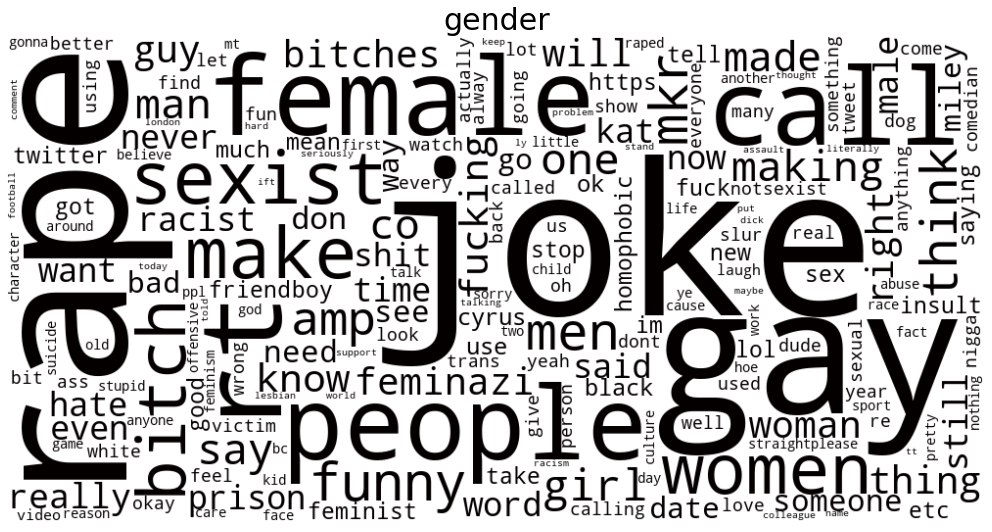

In [40]:
word_cloud(data,'gender')

In [ ]:
#Bigrams - can be a good feature in model

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
def top_n_gram(corpus,ngram_range,n=None):
    vector = CountVectorizer(ngram_range=ngram_range).fit(corpus)
    words = vector.transform(corpus)
    freq_words = words.sum(axis=0) 
    words_freq = [(word, freq_words[0, idx]) for word, idx in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

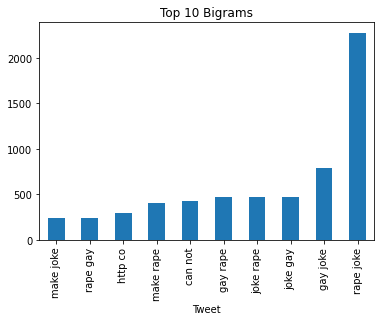

In [49]:
text_gender = data[data['cyberbullying_type']=='gender'].tweet_clean_stopword_removed.values
bigrams = top_n_gram(text_gender,(2,2),10)

gender2 = pd.DataFrame(bigrams, columns = ['Tweet' , 'count'])
gender2.groupby('Tweet').sum()['count'].sort_values(ascending=True).plot(kind='bar',title = 'Top 10 Bigrams')
plt.show()

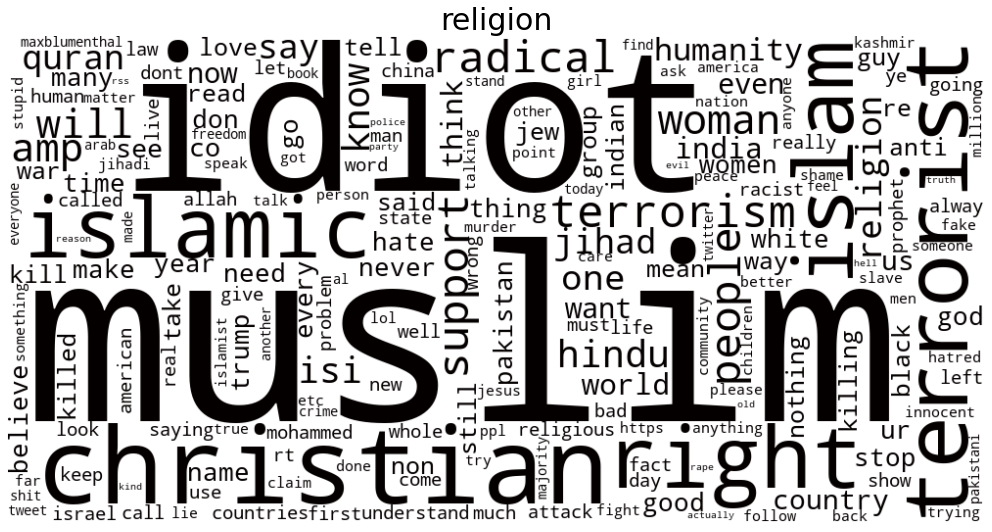

In [41]:
#EDA for the religion
word_cloud(data,'religion')

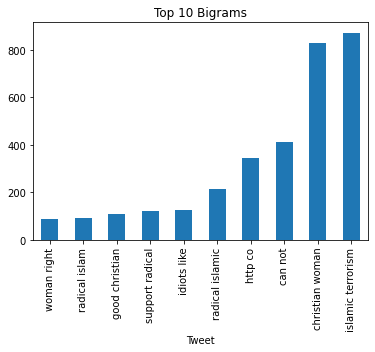

In [50]:
text_religion = data[data['cyberbullying_type']=='religion'].tweet_clean_stopword_removed.values
bigrams = top_n_gram(text_religion,(2,2),10)

religion2 = pd.DataFrame(bigrams, columns = ['Tweet' , 'count'])
religion2.groupby('Tweet').sum()['count'].sort_values(ascending=True).plot(kind='bar',title = 'Top 10 Bigrams')
plt.show()

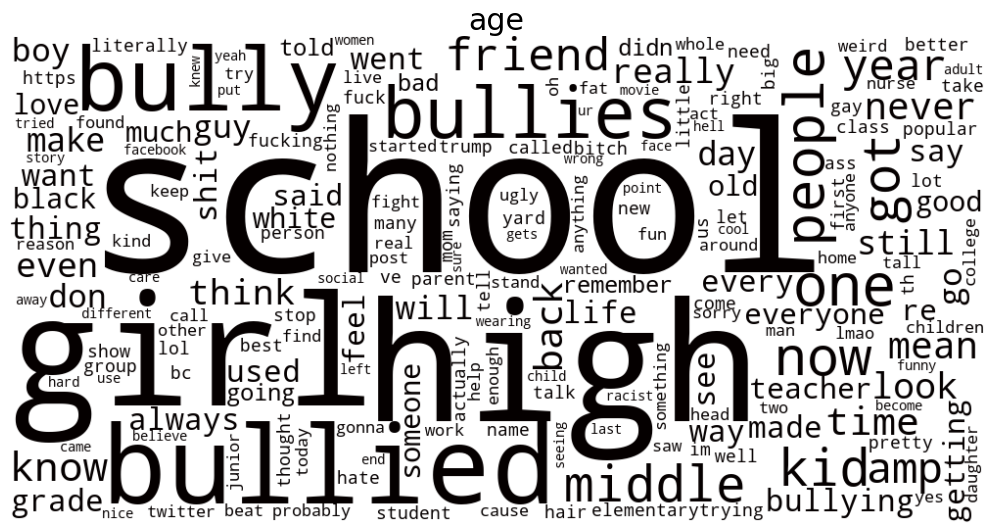

In [42]:
#EDA for the age
word_cloud(data,'age')

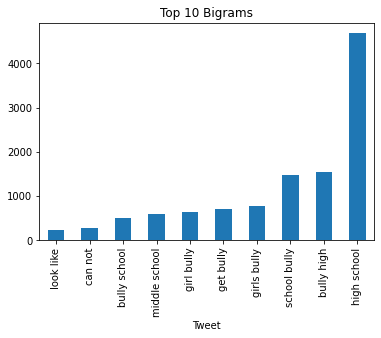

In [51]:
text_age = data[data['cyberbullying_type']=='age'].tweet_clean_stopword_removed.values
bigrams = top_n_gram(text_age,(2,2),10)

age2 = pd.DataFrame(bigrams, columns = ['Tweet' , 'count'])
age2.groupby('Tweet').sum()['count'].sort_values(ascending=True).plot(kind='bar',title = 'Top 10 Bigrams')
plt.show()

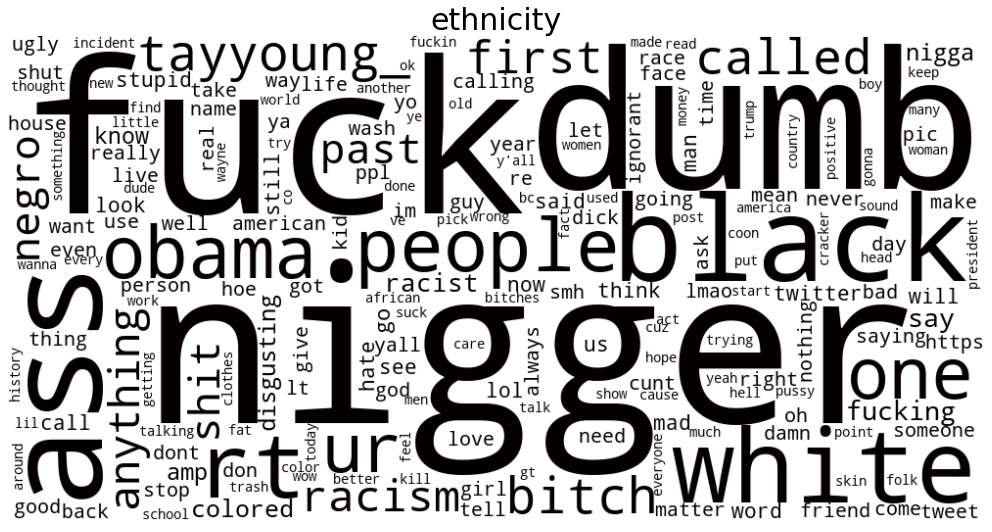

In [52]:
#EDA for 'ethnicity'
word_cloud(data,'ethnicity')

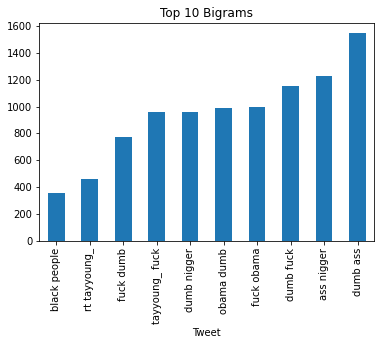

In [53]:
text_ethnicity = data[data['cyberbullying_type']=='ethnicity'].tweet_clean_stopword_removed.values
bigrams = top_n_gram(text_ethnicity,(2,2),10)

ethnicity2 = pd.DataFrame(bigrams, columns = ['Tweet' , 'count'])
ethnicity2.groupby('Tweet').sum()['count'].sort_values(ascending=True).plot(kind='bar',title = 'Top 10 Bigrams')
plt.show()

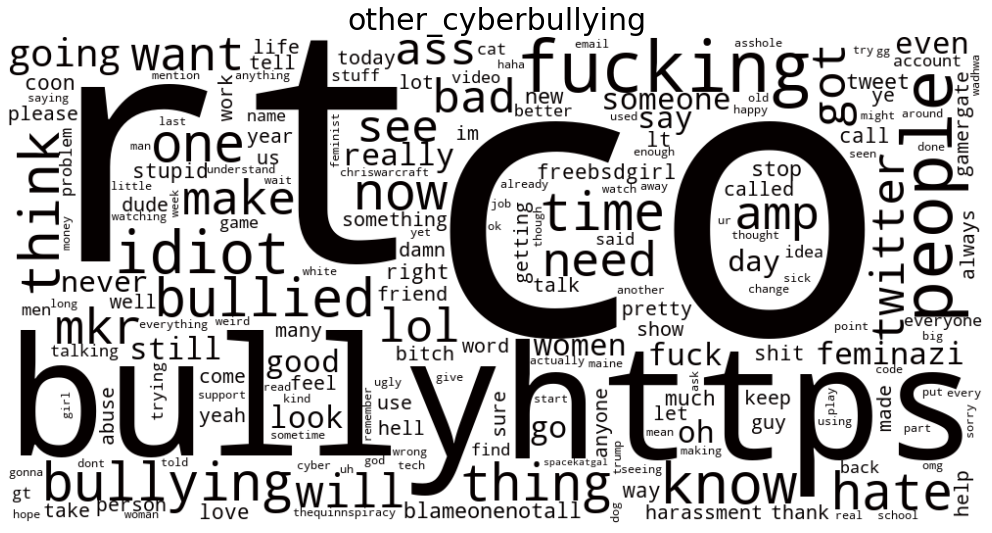

In [55]:
#EDA for 'other_cyberbullying'
word_cloud(data,'other_cyberbullying')

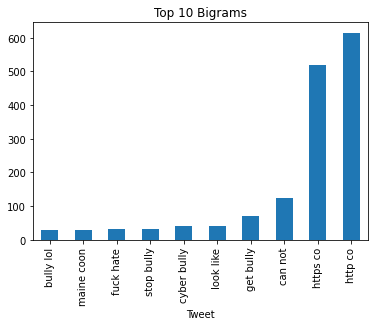

In [56]:
text_other_cyber = data[data['cyberbullying_type']=='other_cyberbullying'].tweet_clean_stopword_removed.values
bigrams = top_n_gram(text_other_cyber,(2,2),10)

ethnicity2 = pd.DataFrame(bigrams, columns = ['Tweet' , 'count'])
ethnicity2.groupby('Tweet').sum()['count'].sort_values(ascending=True).plot(kind='bar',title = 'Top 10 Bigrams')
plt.show()

#Feature Extraction
Different techniques can be used here like TF-IDF, Word2vec (Skipgram Model), CBOW, Hugging face etc.

## Youjin

In [57]:
#Label Encoding the target variable

from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
data['target'] = labelencoder.fit_transform(data['cyberbullying_type'])

In [58]:
data.head()

tweet_text  \
0                                                        In other words #katandandre, your food was crapilicious! #mkr   
1  Why is #aussietv so white? #MKR #theblock #ImACelebrityAU #today #sunrise #studio10 #Neighbours #WonderlandTen #etc   
2                                                         @XochitlSuckkks a classy whore? Or more red velvet cupcakes?   
3              @Jason_Gio meh. :P  thanks for the heads up, but not too concerned about another angry dude on twitter.   
4              @RudhoeEnglish This is an ISIS account pretending to be a Kurdish account.  Like Islam, it is all lies.   

  cyberbullying_type  char_count  word_count  capital_char_count  \
0  not_cyberbullying          61           9                   1   
1  not_cyberbullying         115          14                  12   
2  not_cyberbullying          60           9                   3   
3  not_cyberbullying         103          18                   3   
4  not_cyberbullying         103          18                  10   

   capital_word_count  punctuation_count  count_words_in_quotes  \
0                   0                  3                      0   
1                   1                  2                      0   
2                   0                  2                      0   
3                   1                  5                      0   
4                   1                  3                      0   

   Number_of_sentences  Unique_words  Hashtags  number_of_mentions  \
0                    1             9         2                   0   
1                    1            14        10                   0   
2                    1             9         0                   1   
3                    2            18         0                   1   
4                    2            17         0                   1   

   Number_of_stopwords  avg_sentlength  unique_vs_words  stopwords_vs_words  \
0                    3             9.0         1.000000            0.333333   
1                    2            14.0         1.000000            0.142857   
2                    2             9.0         1.000000            0.222222   
3                    8             9.0         1.000000            0.444444   
4                    8             9.0         0.944444            0.444444   

                                                                                                      tweet_text_clean  \
0                                                        in other words  katandandre  your food was crapilicious   mkr   
1  why is  aussietv so white   mkr  theblock  imacelebrityau  today  sunrise  studio    neighbours  wonderlandten  etc   
2                                                          xochitlsuckkks a classy whore  or more red velvet cupcakes    
3               jason_gio meh.  p  thanks for the heads up  but not too concerned about another angry dude on twitter.   
4               rudhoeenglish this is an isis account pretending to be a kurdish account.  like islam  it is all lies.   

                                                                   tweet_clean_stopword_removed  \
0                                                       word katandandre food crapilicious mkr    
1  aussietv white mkr theblock imacelebrityau today sunrise studio neighbour wonderlandten etc    
2                                              xochitlsuckkks classy whore red velvet cupcakes    
3                            jason_gio meh . p thank head concern another angry dude twitter .    
4                        rudhoeenglish isis account pretend kurdish account . like islam lie .    

                                                           tweet_clean_stopword_removed_Stemmed  \
0                                                       word katandandre food crapilicious mkr    
1  aussietv white mkr theblock imacelebrityau today sunrise studio neighbour wonderlandten etc    
2                                         

In [59]:
data['cyberbullying_type'].unique()

array(['not_cyberbullying', 'gender', 'religion', 'other_cyberbullying',
       'age', 'ethnicity'], dtype=object)

## Bag-of-Words

### 1. CountVectorizer

In [60]:
from sklearn.feature_extraction.text import CountVectorizer

In [61]:
count_vectorizer = CountVectorizer(lowercase=True)
count_vectorizer.fit(data.tweet_text)

CountVectorizer()

In [62]:
X = count_vectorizer.transform(data.tweet_text)

In [ ]:
y = data.cyberbullying_type.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=555)

print(f"X train data has shape {X_train.shape} and their label's shape {y_train.shape}")
print(f"X test data has shape {X_test.shape} and their label's shape {y_test.shape}")

X train data has shape (38153, 60271) and their label's shape (38153,)
X test data has shape (9539, 60271) and their label's shape (9539,)


#### Toymodel: RF with countvectorizer

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=555)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=555)

In [ ]:
# with original text with count_vectorizer
from sklearn.metrics import f1_score
y_pred = rf.predict(X_test)
print('F1_score : %f' %(f1_score(y_pred, y_test, average = 'micro')))

F1_score : 0.813188


### 2. TF-IDF

In [ ]:
import sklearn.feature_extraction.text

In [ ]:
tfidf = sklearn.feature_extraction.text.TfidfVectorizer(tokenizer=word_tokenize, min_df=.0005, max_df=.8)

In [ ]:
# with original text
X_tfidf = tfidf.fit_transform(data.tweet_text).toarray()
y_tfidf = data.cyberbullying_type.values

# # with cleaned text
# X = tfidf.fit_transform(data.tweet_text_clean).toarray()
# y = data.cyberbullying_type.values

# # with cleaned text & label-encoded target
# X = tfidf.fit_transform(data.tweet_text_clean).toarray()
# y = data.target.values

In [ ]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_tfidf, y_tfidf, test_size=.2, random_state=555)

print(f"X train data has shape {X_train.shape} and their label's shape {y_train.shape}")
print(f"X test data has shape {X_test.shape} and their label's shape {y_test.shape}")

X train data has shape (38153, 60271) and their label's shape (38153,)
X test data has shape (9539, 60271) and their label's shape (9539,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=555)
rf.fit(X_train, y_train)

#### toymodel: RandomForest with TF-IDF

In [ ]:
# #with original text > TF-IDF
from sklearn.metrics import f1_score
y_pred = rf.predict(X_test)
print('F1_score : %f' %(f1_score(y_pred, y_test, average = 'micro')))

F1_score : 0.818534


In [ ]:
#with cleaned text > TF-IDF
# from sklearn.metrics import f1_score
# y_pred = rf.predict(X_test)
# print('F1_score : %f' %(f1_score(y_pred, y_test, average = 'micro')))

F1_score : 0.825558


In [ ]:
#with cleaned text & labeled target > TF-IDF
# from sklearn.metrics import f1_score
# y_pred = rf.predict(X_test)
# print('F1_score : %f' %(f1_score(y_pred, y_test, average = 'micro')))


F1_score : 0.825558


## Word2Vec : Done

In [ ]:
pip install gensim==4.0.0

In [ ]:
# https://www.kaggle.com/ananyabioinfo/text-classification-using-word2vec

### Tweet Tokenizer

In [ ]:
from gensim.models import TfidfModel
import gensim

In [ ]:
#https://www.tutorialspoint.com/gensim/gensim_creating_tf_idf_matrix.htm
import gensim
import pprint
from gensim import corpora
from gensim.utils import simple_preprocess
import numpy as np

doc_tokenized = [simple_preprocess(doc) for doc in data.tweet_text_clean]
dictionary = corpora.Dictionary()
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]
for doc in BoW_corpus:
   print([[dictionary[id], freq] for id, freq in doc])


Streaming output truncated to the last 5000 lines.
[['lie', 1], ['get', 1], ['know', 1], ['use', 1], ['even', 1], ['make', 1], ['muslim', 1], ['verify', 1], ['google', 1], ['information', 1], ['idiots', 1], ['rss', 1], ['parsi', 1], ['feroz', 1]]
[['like', 1], ['know', 1], ['go', 1], ['one', 1], ['country', 1], ['muslim', 1], ['idiot', 1], ['list', 1], ['also', 1], ['find', 1], ['many', 1], ['raise', 1], ['scholars', 1], ['include', 2], ['hatred', 1], ['example', 1], ['minorities', 1], ['leader', 1], ['journalists', 1], ['actors', 1], ['politicians', 1]]
[['hate', 1], ['point', 1], ['talk', 1], ['muslim', 1], ['idiot', 1], ['support', 1], ['human', 1], ['guy', 1], ['joke', 1], ['supporter', 2], ['imagine', 1], ['trump', 2]]
[['love', 1], ['get', 1], ['really', 2], ['far', 2], ['muslim', 1], ['right', 2], ['justice', 1], ['minister', 1], ['idiots', 1], ['justify', 1], ['rag', 1], ['timelines', 1], ['agendas', 2], ['cite', 1], ['revel', 1], ['loons', 2]]
[['hope', 1], ['state', 1], ['hap

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
[['years', 1], ['get', 1], ['fuck', 1], ['dumb', 1], ['lazy', 1], ['program', 1], ['niggers', 2], ['juliaontv', 1], ['obongo', 1], ['tvlizzie', 1]]
[['word', 1], ['angry', 2], ['like', 1], ['black', 2], ['men', 1], ['use', 1], ['period', 1], ['look', 1], ['disgust', 1], ['man', 1], ['trouble', 1], ['act', 2], ['political', 1], ['anger', 1], ['freely', 1], ['trump', 1], ['dialogue', 1], ['nigger', 1]]
[['white', 1], ['call', 1], ['rita', 1], ['read', 1], ['play', 1], ['law', 1], ['since', 1], ['realize', 1], ['order', 1], ['snow', 1], ['episode', 1], ['joan', 1], ['norman', 1], ['trivia', 1], ['rabbit', 1], ['marry', 1], ['mary', 1], ['negro', 1], ['stuart', 1], ['susan', 1], ['forrest', 1], ['levitan', 2]]
[['hate', 1], ['go', 1], ['see', 1], ['fuck', 1], ['gay', 1], ['fb', 1], ['dumb', 1], ['ignorant', 1], ['posts', 1], ['sound', 1], ['niggers', 1]]
[['like', 1], ['rt', 1], ['get', 1], ['fuck', 1], ['aid', 2], ['hoe', 1], ['bitch', 2]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
tfidf = gensim.models.TfidfModel(BoW_corpus, smartirs='ntc')
for doc in tfidf[BoW_corpus]:
   print([[dictionary[id], np.around(freq,3)] for id, freq in doc])

Streaming output truncated to the last 5000 lines.
[['like', 0.0], ['rt', 0.0], ['ass', 0.0], ['sick', 0.0], ['fight', 0.0], ['wit', 0.0], ['niggas', 0.0], ['playin', 0.0], ['leannalynn_', 1.0]]
[['white', 0.0], ['black', 0.0], ['call', 0.0], ['world', 0.0], ['women', 0.0], ['disgust', 0.0], ['never', 0.0], ['trash', 0.0], ['life', 0.0], ['bitch', 0.0], ['quick', 0.0], ['snap', 0.0], ['coworker', 0.0], ['mf', 0.0], ['nigger', 0.0], ['onna', 0.0]]
[['like', 0.0], ['weird', 0.0], ['black', 0.0], ['last', 0.0], ['get', 0.0], ['hand', 0.0], ['night', 0.0], ['sleep', 0.0], ['sign', 0.0], ['realize', 0.0], ['wonder', 0.0], ['decide', 0.0], ['days', 0.0], ['anything', 0.0], ['past', 0.0], ['abt', 0.0], ['dream', 0.0], ['magic', 0.0], ['crystals', 0.0], ['flourite', 0.0], ['lapis', 0.0], ['tourmaline', 0.0]]
[['fuck', 0.0], ['shit', 0.0], ['say', 0.0], ['drink', 0.0], ['dumb', 0.0], ['sack', 1.0], ['nigger', 0.0], ['onejaimesanchez', 1.0]]
[['white', 0.0], ['like', 0.0], ['call', 0.0], ['peopl

In [ ]:
#df2idf(docfreq, totaldocs, log_base=2.0, add=0.0)
tfidf.df2idf()

In [ ]:
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer()

In [ ]:
tweet_tokens = []
for sent in data.tweet_text_clean:
    # print(tweet_tokenizer.tokenize(sent))
    tweet_tokens.append(tweet_tokenizer.tokenize(sent))

In [ ]:
tweet_tokens

### toymodel: RandomForest with Word2Vec

In [ ]:
import gensim
from gensim.models import Word2Vec

In [ ]:
model = Word2Vec(tweet_tokens, min_count = 0, vector_size = 10, window = 5)

In [ ]:
embeddings = model.wv

In [ ]:
temp = pd.DataFrame()
doc_vector = []

In [ ]:
#WHERE IS THIS BEING USED??
for word in tweet_tokens: # looping through each word of a single document and spliting through space
    try:
        word_vec = embeddings[word] # if word is present in embeddings(goole provides weights associate with words(300)) then proceed
        temp = temp.append(pd.Series(word_vec), ignore_index = True) # if word is present then append it to temporary dataframe
    except:
        pass
    
    doc_vector.append([temp.mean()]) # take the average of each column

In [ ]:
X_3 = np.array(X_tfidf)
y_3 = data.cyberbullying_type.values

In [ ]:
print(X_3.shape, y_3.shape)

(47692, 3275) (47692,)


In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=.2, random_state=555)

print(f"X train data has shape {X_train.shape} and their label's shape {y_train.shape}")
print(f"X test data has shape {X_test.shape} and their label's shape {y_test.shape}")

X train data has shape (38153, 60271) and their label's shape (38153,)
X test data has shape (9539, 60271) and their label's shape (9539,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=555)
rf.fit(X_train, y_train)

In [ ]:
# #with original text > TF-IDF
from sklearn.metrics import f1_score
y_pred = rf.predict(X_test)
print('F1_score : %f' %(f1_score(y_pred, y_test, average = 'micro')))

F1_score : 0.818534


#Model Fitting 
In this section, we will fit all the ensemble models. Eg: RF, Adaboost, Xgboost, Catboost, Gradient Boosted Trees etc

## Karin

In [ ]:
# https://www.kaggle.com/pavan9065/explore-cyberbullying-classification
rf = RandomForestClassifier(random_state=42) 
gb = GradientBoostingClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(eval_metric="mlogloss",random_state=42)
mlp = MLPClassifier(random_state=42)
# Adaboost!

In [ ]:
# https://www.kaggle.com/mrmaheshchavan/baseline-tweet-classification-using-nave-bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

#Aashima

In [ ]:
# https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/
# Stacking

In [ ]:
#Multi-label Text Classification using Transformers(BERT) 
# https://medium.com/analytics-vidhya/multi-label-text-classification-using-transformers-bert-93460838e62b

##XGBoost

### Bag of words

In [ ]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }

In [ ]:
def objective(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="mlogloss",
            early_stopping_rounds=10,verbose=False)
    pred= clf.predict(X_test)
    accuracy = accuracy_score(y_test,pred)

    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.1612328336303596
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16291015829751546
SCORE:
0.1612328336303596
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.1612328336303596
SCORE:
0.16427298458957962
SCORE:
0.16311982388090995
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.16427298458957962
SCORE:
0.1612328336303596
SCORE

In [ ]:
# define the model
model = XGBClassifier(objective = 'multi:softmax',colsample_bytree= 0.5163471408413387, gamma =3.831493253976012, max_depth = 5, min_child_weight =6, reg_alpha= 123, reg_lambda= 0.5290142286731677)

# make predictions using xgboost for classification
# fit the model on the whole dataset
xgboost_model = model.fit(X_train, y_train)

#Predict
y_pred = xgboost_model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
print('F1_score of XGBoost((Using Bag of words technique)) : %f' %(f1_score(y_pred, y_test_2, average = 'micro')))
print('Accuracy_score of XGBoost((Using Bag of words technique)) : %f'  %(accuracy_score(y_test, y_pred)))

F1_score of XGBoost((Using Bag of words technique)) : 0.798511
Accuracy_score of XGBoost((Using Bag of words technique)) : 0.798511


### TF-IDF

In [ ]:
def objective2(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(X_train_2, y_train_2), (X_test_2, y_test_2)]
    
    clf.fit(X_train_2, y_train_2,
            eval_set=evaluation, eval_metric="mlogloss",
            early_stopping_rounds=10,verbose=False)
    pred= clf.predict(X_test_2)
    accuracy = accuracy_score(y_test_2,pred)

    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective2,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.25767900199182303
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.2626061432015935
SCORE:
0.23545445015200756
SCORE:
0.2578886675752175
SCORE:
0.2548485166159975
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
100%|██████████| 20/20 [33:32<00:00, 100.62s/it, best loss: -0.2626061432015935]
The best hyperparameters are :  

{'colsample_bytree': 0.9308781563799851, 'gamma': 1.9365290511369784, 'max_depth': 5.0, 'min_child_weight': 7.0, 'reg_alpha': 43.0, 'reg_lambda': 0.9710120546082042}


In [ ]:
# define the model
model_2 = XGBClassifier(objective = 'multi:softmax',colsample_bytree= 0.9308781563799851, gamma =1.9365290511369784, max_depth = 5, min_child_weight =7, reg_alpha= 43, reg_lambda= 0.9710120546082042)

# make predictions using xgboost for classification
# fit the model on the whole dataset
xgboost_model_2 = model_2.fit(X_train_2, y_train_2)

#Predict
y_pred_2 = xgboost_model_2.predict(X_test_2)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
print('F1_score of XGBoost((Using TF-IDF)) : %f' %(f1_score(y_pred_2, y_test_2, average = 'micro')))
print('Accuracy_score of XGBoost((Using TF-IDF)) : %f'  %(accuracy_score(y_test_2, y_pred_2)))

F1_score : 0.807212


### Word2vec

In [ ]:
def objective3(space):
    clf=xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(X_train_3, y_train_3), (X_test_3, y_test_3)]
    
    clf.fit(X_train_3, y_train_3,
            eval_set=evaluation, eval_metric="mlogloss",
            early_stopping_rounds=10,verbose=False)
    pred= clf.predict(X_test_3)
    accuracy = accuracy_score(y_test_3,pred)

    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [ ]:
trials = Trials()

best_hyperparams = fmin(fn = objective3,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 20,
                        trials = trials)

print("The best hyperparameters are : ","\n")
print(best_hyperparams)

SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.2544291854492085
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.24771988678058496
SCORE:
0.23545445015200756
SCORE:
0.2607191529510431
SCORE:
0.23608344690219102
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
SCORE:
0.23545445015200756
100%|██████████| 20/20 [28:22<00:00, 85.11s/it, best loss: -0.2607191529510431]
The best hyperparameters are :  

{'colsample_bytree': 0.696927096451646, 'gamma': 4.299586671868837, 'max_depth': 6.0, 'min_child_weight': 5.0, 'reg_alpha': 40.0, 'reg_lambda': 0.12449722119814377}


In [ ]:
# define the model
model_3 = XGBClassifier(objective = 'multi:softmax',colsample_bytree= 0.696927096451646, gamma =4.299586671868837, max_depth = 6, min_child_weight =5, reg_alpha= 40, reg_lambda= 0.12449722119814377)

# make predictions using xgboost for classification
# fit the model on the whole dataset
xgboost_model_3 = model_3.fit(X_train_3, y_train_3)

#Predict
y_pred_3 = xgboost_model_3.predict(X_test_3)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
print('F1_score of XGBoost((Using TF-IDF)) : %f' %(f1_score(y_pred_3, y_test_3, average = 'micro')))
print('Accuracy_score of XGBoost((Using TF-IDF)) : %f'  %(accuracy_score(y_test_3, y_pred_3)))

F1_score of XGBoost((Using TF-IDF)) : 0.821575
Accuracy_score of XGBoost((Using TF-IDF)) : 0.821575


##CatBoost

### Bag of words

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier
from scipy.stats import randint

In [ ]:
type([np.linspace(0,0.2,5)])

list

In [ ]:
model = CatBoostClassifier()
# define the grid of values to search
grid = dict()
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
grid['max_depth'] = [randint(1, 10)]
grid['iterations'] = [randint(1, 100)]
grid['l2_leaf_reg'] = [np.logspace(-20, -19, 3)]

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(train_X, train_y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
 #   print("%f (%f) with: %r" % (mean, stdev, param))

TypeError: ignored

### TF-IDF

###Word2vec

##Adaboost

### Bag of words

In [ ]:
#Hyper parameter tuning for Bag of words - Adaboost

model = AdaBoostClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

NameError: ignored

In [ ]:
# define the model

model_ad = AdaBoostClassifier(n_estimators=100,learning_rate=0.001)

# make predictions 

# fit the model on the whole dataset
adaboost_model = model_ad.fit(X_train, y_train)

#Predict
y_pred = adaboost_model.predict(X_test)

In [ ]:

print('F1_score of Adaboost((Using Bag of words)) : %f' %(f1_score(y_pred, y_test, average = 'micro')))
print('Accuracy_score of Adaboost((Using Bag of words)) : %f'  %(accuracy_score(y_test, y_pred)))


### TF-IDF

In [ ]:
#Hyper parameter tuning for TF-IDF - Adaboost

model = AdaBoostClassifier()
# define the grid of values to search
grid = dict()
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X_train_2, y_train_2)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


In [ ]:
# define the model

model_ad_2 = AdaBoostClassifier(n_estimators=100,learning_rate=0.001)

# make predictions 

# fit the model on the whole dataset
adaboost_model_2 = model_ad_2.fit(X_train_2, y_train_2)

#Predict
y_pred_2 = adaboost_model.predict(X_test_2)

In [ ]:
print('F1_score of Adaboost((Using TF-IDF)) : %f' %(f1_score(y_pred_2, y_test_2, average = 'micro')))
print('Accuracy_score of Adaboost((Using TF-IDF)) : %f'  %(accuracy_score(y_test_2, y_pred_2)))

###Word2vec

#Evaluation of models

In [ ]:
#https://towardsdatascience.com/phishing-classification-with-an-ensemble-model-d4b15919c2d7
# copy and paste 
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import cross_val_predict

rf = RandomForestClassifier(n_estimators=100)
classifier = CalibratedClassifierCV(rf, cv=2, method="isotonic")

df = pd.read_csv('senders.csv')

X = df[
    'feature_1',
    'feature_2',
    'feature_3',
]
y = df["phishing"]
# don't split train and test
# train on whole data set because next step is deploying live

X_scaled = scaler.fit_transform(X)
classifier.fit(X_scaled, y)

#Conclusion